#이미지 분류 데이터 준비

In [ ]:
import os
import urllib.request
import zipfile

#data 폴더가 존재하지 않는 경우.. 만든다

data_dir = './data/'

if not os.path.exists(data_dir):
    
    os.mkdir(data_dir)

In [ ]:
#imageNet의 class index 다운
#keras 제공

url = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'

save_path = os.path.join(data_dir,'imagenet_class_index.json')

if not os.path.exists(save_path):
    
    urllib.request.urlretrieve(url,save_path)

In [ ]:
#pytorch 튜토리얼 제공
#개미와 벌의 이미지 데이터

url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
save_path = os.path.join(data_dir, "hymenoptera_data.zip")

if not os.path.exists(save_path):
    
    urllib.request.urlretrieve(url,save_path)

    #zip파일 읽기
    zip = zipfile.ZipFile(save_path)
    zip.extractall(data_dir) #zip을 압축해제
    zip.close() #zip파일을 닫느다.

    #zip파일 삭제
    os.remove(save_path)

# import package

In [ ]:
#import package

import glob

import os.path as osp

import random

import numpy as np

import json

from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline


import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

In [ ]:
#난수 시드 설정
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

# Dataset class 작성

이미지 전처리 클래스

In [ ]:
#입력 이미지의 전처리 클래스
#훈련시와 추론시 처리가 다르다

class ImageTransform():
    
    """
    이미지 전처리 클래스, 훈련시, 검증시의 동작이 다르다.
    이미지 크기를 리사이즈하고, 색상을 표준화

    훈련시에는 RandomResizedCrop과 RandomHorizontalFlip으로 데이터 확장

    Attributes
    ---------------
    resize: int
        리사이즈 대상 이미지의 크기

    mean: (R,G,B)
        각 색상 채널의 평균값
    
    std : (R,G,B)
        각 색상 채널의 표준편차
    """

    def __init__(self, resize, mean, std):
        
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(
                    resize,scale = (0.5,1.0) #데이터 확장
                ),
                transforms.RandomHorizontalFlip(), #데이터 확장
                transforms.ToTensor(), #텐서 변환
                transforms.Normalize(mean,std) #표준화
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize), #리사이즈
                transforms.CenterCrop(resize), #이미지 중앙을 resize*resize로 자르기
                transforms.ToTensor(), #텐서로 변환
                transforms.Normalize(mean,std) #표준화
            ])
        }

    def __call__(self,img,phase='train'):
        
        """
        Parameters
        -----------
        phase: 'train' or 'val'
            전처리 모드를 지정
        """

        return self.data_transform[phase](img)


실제 동작 확인하기

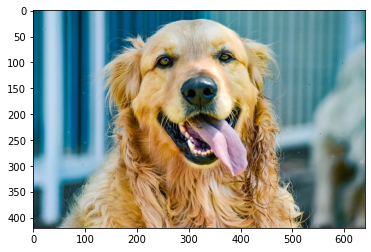

In [ ]:
#훈련할때 이미지 전처리 확인

#1. 이미지 읽기

image_file_path = '/content/data/goldenretriever.jpg'
img = Image.open(image_file_path) #[높이][폭][색]

#2. 원본 이미지 표시
plt.imshow(img)
plt.show()

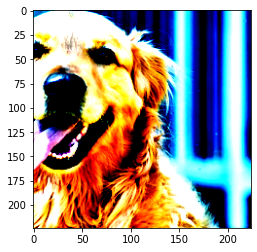

In [ ]:
#3. 이미지 전처리, 처리된 이미지 표시

size = 224

mean = (0.485, 0.456, 0.406)

std = (0.229, 0.224, 0.225)

transform = ImageTransform(size,mean,std)
img_transformed = transform(img,phase='train') #torch.Size([3,224,224])

#(색,높이,너비)를 (높이, 너비, 색상)으로 바꾸고 0-1로 값을 제한해 표시

img_transformed = img_transformed.numpy().transpose((1,2,0))
img_transformed = np.clip(img_transformed, 0,1)

#실행할때마다 결과가 다르다(random)
plt.imshow(img_transformed)
plt.show()

개미와 벌의 이미지 파일 경로 리스트를 작성

In [ ]:
#개미와 벌이 담긴 이미지 파일의 경로 리스트 작성하기
def make_datapath_list(phase="train"):
    
    """
    데이터의 경로를 저장한 리스트를 작성한다.

    parameters
    -----------
    phase: 'train' or 'val'
        훈련 데이터 또는 검증 데이터를 지정
    
    Returns
    -----------
    path_list : list
        데이터 경로를 저장한 리스트
    """

    rootpath = "./data/hymenoptera_data/"
    target_path = osp.join(rootpath+phase+'/**/*.jpg')
    print(target_path)

    path_list = [] #여기에 저장

    #glob를 이용하여 하위 디렉토리의 파일 경로를 가져온다
    for path in glob.glob(target_path):
        
        path_list.append(path)
    
    return path_list

#실행
train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")

train_list

./data/hymenoptera_data/train/**/*.jpg
./data/hymenoptera_data/val/**/*.jpg


['./data/hymenoptera_data/train/ants/82852639_52b7f7f5e3.jpg',
 './data/hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg',
 './data/hymenoptera_data/train/ants/392382602_1b7bed32fa.jpg',
 './data/hymenoptera_data/train/ants/512164029_c0a66b8498.jpg',
 './data/hymenoptera_data/train/ants/470127037_513711fd21.jpg',
 './data/hymenoptera_data/train/ants/540889389_48bb588b21.jpg',
 './data/hymenoptera_data/train/ants/342438950_a3da61deab.jpg',
 './data/hymenoptera_data/train/ants/2265825502_fff99cfd2d.jpg',
 './data/hymenoptera_data/train/ants/1804095607_0341701e1c.jpg',
 './data/hymenoptera_data/train/ants/swiss-army-ant.jpg',
 './data/hymenoptera_data/train/ants/6743948_2b8c096dda.jpg',
 './data/hymenoptera_data/train/ants/0013035.jpg',
 './data/hymenoptera_data/train/ants/Ant_1.jpg',
 './data/hymenoptera_data/train/ants/822537660_caf4ba5514.jpg',
 './data/hymenoptera_data/train/ants/318052216_84dff3f98a.jpg',
 './data/hymenoptera_data/train/ants/207947948_3ab29d7207.jpg',
 './data/h

dataset 클래스 작성

In [ ]:
#개미와 벌의 이미지에 대한 dataset 작성

class HymenopteraDataset(data.Dataset):
    
    """
    개미와 벌 이미지의 dataset class
    PyTorch의 dataset 클래스를 상속

    attributes
    -----------
    file_list : 리스트
        화상 경로를 저장한 리스트
    transform : object
        전처리 클래스의 인스턴스
    phase : 'train' or 'test'
        학습인지 훈련인지를 설정
    """

    def __init__(self, file_list, transform=None, phase='train'):
        
        self.file_list = file_list #파일 경로 리스트
        self.transform = transform #전처리 클래스의 인스턴스
        self.phase = phase #train or val 지정

    def __len__(self):
        
        """이미지 개수를 반환"""
        return len(self.file_list)
    
    def __getitem__(self,index):
        
        """
        전처리한 이미지의 tensor 형식의 데이터와 라벨 취득
        """

        #index번째의 이미지를 로드
        img_path = self.file_list[index]
        img = Image.open(img_path) #[높이][너비][색]

        #이미지 전처리
        img_transformed = self.transform(
            img, self.phase) #torch.Size([3,224,224])
            
        #이미지 라벨을 파일 이름에서 추출
        if self.phase == 'train':
            
            label = img_path[30:34]
        
        elif self.phase == 'val':
            
            label = img_path[28:32]
        
        #라벨을 숫자로 변경
        if label == 'ants':
            
            label = 0
        
        elif label == 'bees':
            
            label = 1
        
        return img_transformed, label

In [ ]:
#실행
train_dataset = HymenopteraDataset(
    file_list = train_list, transform = ImageTransform(size,mean,std), phase='train'
)

val_dataset = HymenopteraDataset(
    file_list = val_list, transform = ImageTransform(size,mean,std), phase='val'
)

#동작 확인

index = 0
print(train_dataset.__getitem__(index)[0].size()) #이미지 텐서 크기
print(train_dataset.__getitem__(index)[1]) #라벨

torch.Size([3, 224, 224])
0


# dataloader 작성

In [ ]:
#미니 배치 크기
batch_size = 32

#dataloader 작성
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size = batch_size, shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size = batch_size, shuffle=False
)

#쉽게 다루기 위해 사전형 변수에 정리
dataloaders_dict = {"train":train_dataloader, "val": val_dataloader}

#동작 확인
#반복자(iterator)로 변환
batch_iterator = iter(dataloaders_dict["train"])
inputs, labels = next(
    batch_iterator) #첫번째 요소를 추출
print(inputs.size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 1, 0, 1, 0, 0])


# 네트워크 모델 작성

In [ ]:
#학습된 vgg-16 모델을 로드
#vgg-16 모델의 인스턴스를 생성

use_pretrained = True #학습된 파라미터를 사용한다
net = models.vgg16(pretrained = use_pretrained)

#vgg-16의 마지막 출력층의 출력 유닛을 개미, 벌 2개로 바꾼다

net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

#훈련 모드
net.train()

print("네트워크 설정 완료: 학습된 가중치를 읽어들여 훈련 모드로 설정했다.")

네트워크 설정 완료: 학습된 가중치를 읽어들여 훈련 모드로 설정했다.


# 손실 함수 정의

In [ ]:
#손실 함수 설정
criterion = nn.CrossEntropyLoss()

# 최적화 기법

In [ ]:
#전이학습에서 학습시킬 파라미터를 params_to_update 변수에 저장
params_to_update = []

#학습시킬 파라미터 이름
update_param_names = ["classifier.6.weight", "classifier.6.bias"]

#학습시킬 파라미터 이외에는 gradient를 계산하지 않고, 변하지 않게 설정
for name, param in net.named_parameters():
    if name in update_param_names:
        
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    
    else:
        
        param.requires_grad = False

#params_to_update의 내용을 확인
print("---------------")
print(params_to_update)


classifier.6.weight
classifier.6.bias
---------------
[Parameter containing:
tensor([[-0.0041,  0.0130, -0.0102,  ...,  0.0073, -0.0008, -0.0009],
        [ 0.0020,  0.0040,  0.0104,  ..., -0.0022, -0.0120,  0.0133]],
       requires_grad=True), Parameter containing:
tensor([-0.0107, -0.0090], requires_grad=True)]


In [ ]:
#최적화 기법 설정
optimizer = optim.SGD(params = params_to_update, lr = 0.001, momentum = 0.9)

# 학습 및 검증 실시

In [ ]:
#모델을 학습시키는 함수 작성

def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    
    #epoch 루프
    for epoch in range(num_epochs):
        
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('------------')

        #epoch별 학습 및 검증 루프
        for phase in ['train','val']:
            
            if phase == 'train':
                
                net.train() #모델을 훈련모드로
            
            else:
                
                net.eval() #모델을 검증 모드로

        
            epoch_loss = 0.0 #epoch 손실의 합
            epoch_corrects = 0 #epoch 정답의 수

            #미 학습시 검증 성능을 확인하기 위해 epoch=0의 훈련 생략
            if (epoch == 0) and (phase == 'train'):
                
                continue
            
            #데이터 로더로 미니 배치를 꺼내는 루프
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                
                #optimizer를 초기화
                optimizer.zero_grad()

                #forward path
                with torch.set_grad_enabled(phase == 'train'):
                    
                    outputs = net(inputs)
                    loss = criterion(outputs, labels) #손실
                    _, preds = torch.max(outputs, 1) #라벨

                    #훈련시에는 역전파
                    if phase == 'train':
                        
                        loss.backward()
                        optimizer.step()
                    
                    #반복 결과 계산
                    #loss 합계 갱신

                    epoch_loss += loss.item() * inputs.size(0)

                    #정답 수의 합계 갱신
                    epoch_corrects += torch.sum(preds == labels.data)
            
            #epoch당 loss와 정답률 표시

            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)

            epoch_acc = epoch_corrects.double()/len(dataloaders_dict[phase].dataset)

            print('{}: Loss:{:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

In [ ]:
#학습, 검증 실시
num_epochs = 3
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/3
------------


100%|██████████| 5/5 [01:15<00:00, 15.16s/it]


val: Loss:0.7445 Acc: 0.4248
Epoch 2/3
------------


100%|██████████| 8/8 [02:04<00:00, 15.54s/it]


train: Loss:0.4750 Acc: 0.7695


100%|██████████| 5/5 [01:14<00:00, 14.96s/it]


val: Loss:0.1814 Acc: 0.9477
Epoch 3/3
------------


100%|██████████| 8/8 [02:00<00:00, 15.09s/it]


train: Loss:0.1355 Acc: 0.9383


100%|██████████| 5/5 [01:14<00:00, 14.98s/it]

val: Loss:0.1248 Acc: 0.9608
